# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:
# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

#GrandMatrix
#!wget https://upscfever.com/upsc-fever/en/data/deeplearning4/images/NST_GM.png

# Creamos el directorio para los archivos de salida
!mkdir /content/output

--2020-09-29 14:49:15--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.1’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.02s   

2020-09-29 14:49:15 (11.5 MB/s) - ‘La_noche_estrellada1.jpg.1’ saved [223725/223725]

--2020-09-29 14:49:15--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) 

In [ ]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

2.3.0


In [ ]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
result_prefix = Path("/content/output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:  
La primer celda hace referecia a los valores que tomarán **$\alpha$** (**content_weight**) y **$\beta$** (**style_weight**) en la Loss definida en el paper.  


$$L_{total}(\vec{p},\vec{a},\vec{x}) = \alpha L_{content}(\vec{p},\vec{x}) + \beta J_{style}(\vec{a},\vec{x})$$

**total_variation_weigh** es utilizado como un término de regularización dentro de la Loss total. (https://www.tensorflow.org/tutorials/generative/style_transfer)  

La segunda celda servirá para el resize de las imágenes y que estas tengan las mismas medidas


In [ ]:
total_variation_weight = 0.1
style_weight = 1 #10
content_weight = 10 #1

In [ ]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [ ]:
print('medida original:',width,'x',height)
print('medida resize  :',img_nrows,'x',img_ncols)

medida original: 775 x 599
medida resize  : 400 x 517


# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:  
Esta función está preparando la imágen de entrada para que sea aceptada por el modelo en cuenanto a los requerimientos de este.  
La dos ultimas lineas se refieren a:  
**np.expand** agrega una dimención mas entendiendo que esto trabaja con batches de imagenes, por lo que necesita en un batch con la imagen, por lo que el shape será ahora (imagenes, alto, ancho, canales)  
**vgg19.preprocess_input** prepara la imágen según lo requiera el modelo, en este caso VGG19.  
Esto lo hace porque adecua la imagen a las necesidades del modelo.


In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
img = load_img(base_image_path, target_size=(img_nrows, img_ncols))

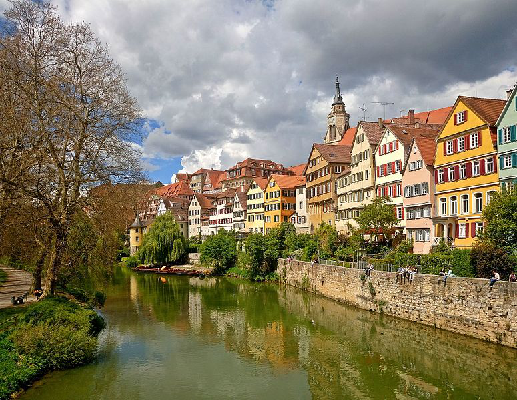

In [ ]:
img

In [ ]:
img = img_to_array(img)

In [ ]:
img.shape

(400, 517, 3)

In [ ]:
img = np.expand_dims(img, axis=0)

In [ ]:
img.shape

(1, 400, 517, 3)

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:  
**deprocess_image**  
La siguiente celda recibie un numpy array en algúna dimencion que coincide con img_nrows x img_ncols x 3 y lo acomoda a una forma entendible como imagen de 3 canales.  

A cada uno de los canales incrementa cada pixel en un valor predeterminado sacandose de encima los valores 0.  

Luego, intercambia de lugares los canales R con G para que sea una imagen entendible en el formato RGB.  

Al final de todo, se queda solo con valores enteros de 0 a 255

In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

La **matriz de Gram** es la *matriz de estilo*  

Se utiliza $G_{ij}$ para comparar cuan similar es $v_i$ con $v_j$: Si son muy similares, se espera que el producto punto sea alto.

<img src="https://upscfever.com/upsc-fever/en/data/deeplearning4/images/NST_GM.png" style="width:900px;height:300px;">
$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$


la función **permute_dimensions** hace lo mismo que *np.transpose()* y tendrá esos features "desenrrollados" (flatten)

In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

https://keras.io/examples/generative/neural_style_transfer/

La **style_loss** es donde se mantiene el deep learning, que se define mediante una red neuronal convolucional profunda. Precisamente, consiste en una suma de distancias L2 entre las matrices Gram de las representaciones de la imagen base y la imagen de referencia de estilo, extraídas de diferentes capas de un convnet. La idea general es capturar información de color / textura a diferentes escalas espaciales (escalas bastante grandes, definidas por la profundidad de la capa considerada).  

la  **content_loss** content_loss es una distancia L2 entre las características de la imagen base (extraída de una capa profunda) y las características de la imagen combinada, manteniendo la imagen generada lo suficientemente cerca de la original.  

La **total_variation_loss** impone una continuidad espacial local entre los píxeles de la imagen combinada, dándole coherencia visual.

In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:  

En el paper no menciona la utilización de una función de optimización y aquí se emplea esta que toma la Loss total para minimizarla utilizando el algoritmo bfgs sobre la imágen generada

In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [ ]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())

    #fname = result_prefix / ('output_at_iteration_%d.png' % i)
    fname = result_prefix / ('output_S%02d_C%02d_iter_%02d.png' % (style_weight,content_weight, i))
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 4408508400.0
Image saved as /content/output/output_S01_C10_iter_00.png
Iteration 0 completed in 13s
Start of iteration 1
Current loss value: 2731730700.0
Image saved as /content/output/output_S01_C10_iter_01.png
Iteration 1 completed in 13s
Start of iteration 2
Current loss value: 2173867000.0
Image saved as /content/output/output_S01_C10_iter_02.png
Iteration 2 completed in 13s
Start of iteration 3
Current loss value: 1887470100.0
Image saved as /content/output/output_S01_C10_iter_03.png
Iteration 3 completed in 13s
Start of iteration 4
Current loss value: 1741087900.0
Image saved as /content/output/output_S01_C10_iter_04.png
Iteration 4 completed in 13s
Start of iteration 5
Current loss value: 1622736600.0
Image saved as /content/output/output_S01_C10_iter_05.png
Iteration 5 completed in 13s
Start of iteration 6
Current loss value: 1544670500.0
Image saved as /content/output/output_S01_C10_iter_06.png
Iteration 6 completed in 13s
Start of iter

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:  

<img src="content_style.png">


En la primera fila de imágenes (Fig 1,2 y 3) puede observarse la secuencia de generación desde la iteración 0 hasta la iteración 99 donde se corrió con el peso del estilo 10 veces superior al peso del contenido y en la segunda fila (Fig 4, 5 y 6) se realizó invirtiendo los pesos donde ahora el contenido tenía un peso 10 veces superior al del estilo.

Estas diferencias en los pesos de cada uno puede verse, por ejemplo en la figura 3 donde puede distingirse el "sol" en el cielo que proviene del estilo donde además se pierden detalles del propio contenido y se gana razgos del estilo.

Para el caso de la segunda fila donde el mayor peso se lo lleva el contenido, en la figura 6 no solo puede verse un cielo nublado como el original, sino que también los detalles de las ventanas son más marcados.


<img src="comparacion/comparacion.png">



# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

Para esta parte tomé una foto familiar en un lugar icónico para nosotros junto con la obra de **Milo Lockett**, artista plástico chaqueño, que conocí su obra cuando mis híjos "cursaba" el jardín.  


<img src="style_transfer_family.jpg">